In [43]:
import pandas as pd
import numpy as np
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from astropy.io import fits
from math import log10

# Database Connection

In [44]:
from src.database.connection import DATABASE_URL

engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()


# Functions definition

In [45]:
def classify_spectral(teff):
    if teff is None or np.isnan(teff):
        return None
    if teff > 28000:
        return 'O'
    elif 10000 <= teff <= 28000:
        return 'B'
    elif 7500 <= teff < 10000:
        return 'A'
    elif 6000 <= teff < 7500:
        return 'F'
    elif 5200 <= teff < 6000:
        return 'G'
    elif 3700 <= teff < 5200:
        return 'K'
    elif teff < 3700:
        return 'M'
    else:
        return None

In [46]:
def classify_lum_logg(logg):
    """
    Classe de luminosité basée sur logg, en utilisant 
    toute la nomenclature (Ia-O, Ia, Ib, II, III, IV, V, VI, D).
    
    Les seuils sont définis empiriquements
    """
    if logg is None or np.isnan(logg):
        return None

    if logg < 0.0:
        return 'Ia-O'
    elif 0.0 <= logg < 0.5:
        return 'Ia'
    elif 0.5 <= logg < 1.0:
        return 'Ib'
    elif 1.0 <= logg < 1.5:
        return 'II'
    elif 1.5 <= logg < 3.0:
        return 'III'
    elif 3.0 <= logg < 3.5:
        return 'IV'
    elif 3.5 <= logg < 5.0:
        return 'V'
    elif 5.0 <= logg < 7.0:
        return 'VI'
    elif logg >= 7.0:
        return 'D'
    else:
        return None



In [47]:
def classify_lum_j(parallax_mas, j_val):

    if (parallax_mas is None or np.isnan(parallax_mas) or parallax_mas <= 0.0 or
        j_val is None or np.isnan(j_val)):
        return None
    
    d_pc = 1000.0 / parallax_mas

    M_j = j_val + 5.0 - 5.0 * np.log10(d_pc)

    if M_j <= -9:
        return 'Ia-O'
    elif -9 < M_j <= -7:
        return 'Ia'
    elif -7 < M_j <= -5:
        return 'Ib'
    elif -5 < M_j <= -2:
        return 'II'
    elif -2 < M_j <= 2:
        return 'III'
    elif 2 < M_j <= 4:
        return 'IV'
    elif 4 < M_j <= 9:
        return 'V'
    elif 9 < M_j <= 12:
        return 'VI'
    elif M_j > 12:
        return 'D'
    else:
        return None


In [48]:
light_classes_vector = []

# Absolute magnitudes of the Sun in the J, H, K bands
M_sun_J = 3.64
M_sun_H = 3.32
M_sun_K = 3.28

def classify_lum_jhk(parallax_mas, j_val, h_val, k_val):
    """
    Approximates the luminosity class using the J, H, K bands.
    
    1) Calculates the absolute magnitude in each band (M_J, M_H, M_K)
       using the parallax (in milliarcseconds).
    2) Normalizes each absolute magnitude relative to that of the Sun.
    3) Calculates an average (or "pseudo" absolute magnitude):
         M_avg = (M_J + M_H + M_K) / 3
    4) Applies empirical thresholds to classify (Ia-O, Ia, Ib, II, III, IV, V, VI, D).
    
    Parameters
    ----------
    parallax_mas : float
        Parallax in milliarcseconds. Must be > 0 to calculate a distance.
    j_val, h_val, k_val : float
        Apparent magnitudes in the J, H, K bands.
    
    Returns
    -------
    str : the luminosity class (Ia-O, Ia, Ib, II, III, IV, V, VI, D)
          or None if it cannot be determined.
    """
    # Basic checks: if any value is invalid
    if (parallax_mas is None or parallax_mas <= 0 or np.isnan(parallax_mas) or
        j_val is None or np.isnan(j_val) or
        h_val is None or np.isnan(h_val) or
        k_val is None or np.isnan(k_val)):
        return None

    # Distance in parsecs
    d_pc = 1000.0 / parallax_mas

    # Distance modulus formula: M_lambda = m_lambda + 5 - 5*log10(d)
    M_j = j_val + 5.0 - 5.0 * np.log10(d_pc) - M_sun_J
    M_h = h_val + 5.0 - 5.0 * np.log10(d_pc) - M_sun_H
    M_k = k_val + 5.0 - 5.0 * np.log10(d_pc) - M_sun_K

    # Calculate the average absolute magnitude (simple arithmetic mean)
    M_avg = (M_j + M_h + M_k) / 3.0
    
    light_classes_vector.append(M_avg)

    # Empirical thresholds (may vary across literature)
    if M_avg <= -9:
        return 'Ia-O'  
    elif -9 < M_avg <= -7:
        return 'Ia'
    elif -7 < M_avg <= -5:
        return 'Ib'
    elif -5 < M_avg <= -2:
        return 'II'
    elif -2 < M_avg <= 2:
        return 'III'
    elif 2 < M_avg <= 4:
        return 'IV'
    elif 4 < M_avg <= 9:
        return 'V'
    elif 9 < M_avg <= 12:
        return 'VI'
    elif M_avg > 12:
        return 'D'
    else:
        return None


# Fetch data

In [49]:
from src.database.creation import DatabaseTables
Star = DatabaseTables.Star

In [50]:
query = session.query(Star).limit(1000000)
results = query.all()

In [51]:
data = []
for star_obj in results:
    row = {
        'apogee_id': star_obj.apogee_id,
        'teff': star_obj.teff,
        'logg': star_obj.logg,
        'j': star_obj.j,
        'h': star_obj.h,
        'k': star_obj.k,
    }
    data.append(row)

df = pd.DataFrame(data)

In [52]:
# for each stars, remove the rows if the value of j h k or ,teff or logg is an outlier (0.01 quantile et 0.99 quantile)

# remove rows where teff is an outlier

df = df[(df['teff'] > df['teff'].quantile(0.01)) & (df['teff'] < df['teff'].quantile(0.99))]

# remove rows where logg is an outlier

df = df[(df['logg'] > df['logg'].quantile(0.01)) & (df['logg'] < df['logg'].quantile(0.99))]

# remove rows where j is an outlier

df = df[(df['j'] > df['j'].quantile(0.01)) & (df['j'] < df['j'].quantile(0.99))]

# remove rows where h is an outlier

df = df[(df['h'] > df['h'].quantile(0.01)) & (df['h'] < df['h'].quantile(0.99))]

# remove rows where k is an outlier

df = df[(df['k'] > df['k'].quantile(0.01)) & (df['k'] < df['k'].quantile(0.99))]



In [53]:
# load original data : 
hdulist = fits.open('../../data/allStarLite-dr17-synspec_rev1.fits')
hdu1_data = hdulist[1].data
df4 = pd.DataFrame(hdu1_data.tolist(), columns=hdu1_data.names)

In [54]:
# Keep GAIAEDR3_PARALLAX and APOGEE_ID
df4 = df4[['GAIAEDR3_PARALLAX', 'APOGEE_ID']]

In [55]:
# Crossmatch and add parallax to df thanks to APOGEE_ID
df = df.merge(df4, how='left', left_on='apogee_id', right_on='APOGEE_ID')
df.drop(columns='APOGEE_ID', inplace=True)

In [56]:
# only keep rows with non missing values
df = df.dropna()

In [57]:
df.describe()

,teff,logg,j,h,k,GAIAEDR3_PARALLAX
count,610482.000000,610482.000000,610482.000000,610482.000000,610482.000000,610482.000000
mean,4945.242804,3.115508,11.387098,10.794684,10.634855,1.799251
std,897.819705,1.167399,1.277701,1.201384,1.195563,2.583580
min,3361.576416,0.509063,7.912000,7.623000,7.711000,-10.957157
25%,4466.093384,2.341344,10.522000,9.992000,9.835000,0.261356
50%,4809.743652,2.991159,11.419000,10.861000,10.718000,0.766211
75%,5203.640137,4.295587,12.320000,11.654000,11.472000,2.506263
max,11031.777344,4.678965,14.772000,13.643000,13.245000,93.165512


# Classification

In [58]:
df['class_spectral'] = df['teff'].apply(classify_spectral)

# descrine spectrla class
df['class_spectral'].value_counts()


class_spectral
K    440917
G    100331
F     40712
M     16452
A      9072
B      2998
Name: count, dtype: int64

In [59]:
df['class_lum_logg'] = df['logg'].apply(classify_lum_logg)

# describe lum logg class
df['class_lum_logg'].value_counts()

class_lum_logg
V      257679
III    245424
IV      46637
II      36370
Ib      24372
Name: count, dtype: int64

In [60]:
df['class_lum_j'] = df.apply(
    lambda x: classify_lum_j(x['GAIAEDR3_PARALLAX'], x['j']),
    axis=1
)

# describe lum j class
df['class_lum_j'].value_counts()

class_lum_j
III     286202
IV      117862
V       104670
II       74247
Ib        7278
Ia        2274
Ia-O      1429
VI          49
Name: count, dtype: int64

In [61]:

df['class_lum_h'] = df.apply(
    lambda x: classify_lum_j(x['GAIAEDR3_PARALLAX'], x['h']),
    axis=1
)

# describe lum j class
df['class_lum_h'].value_counts()

class_lum_h
III     270651
IV      123846
II       99788
V        78499
Ib       15191
Ia        3721
Ia-O      2277
VI          38
Name: count, dtype: int64

In [62]:

df['class_lum_k'] = df.apply(
    lambda x: classify_lum_j(x['GAIAEDR3_PARALLAX'], x['k']),
    axis=1
)

# describe lum j class
df['class_lum_k'].value_counts()

class_lum_k
III     263216
IV      126248
II      107274
V        71377
Ib       18773
Ia        4487
Ia-O      2614
VI          22
Name: count, dtype: int64

In [63]:
df['class_lum_jhk'] = df.apply(
    lambda x: classify_lum_jhk(x['GAIAEDR3_PARALLAX'], x['j'], x['h'], x['k']),
    axis=1
)

# describe lum jhk class
df['class_lum_jhk'].value_counts()

class_lum_jhk
III     222706
II      213934
Ib       92055
Ia       36421
IV       16557
Ia-O     12019
V          319
Name: count, dtype: int64

In [64]:
import matplotlib.pyplot as plt

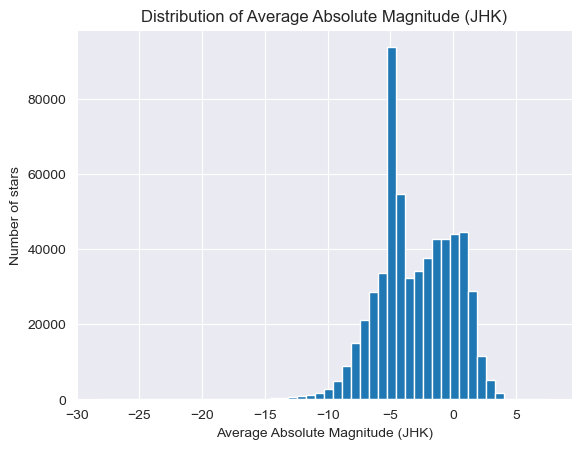

In [65]:
light_classes_vector = np.array(light_classes_vector)

# show distribution of light classes
plt.hist(light_classes_vector, bins=50)
plt.xlabel('Average Absolute Magnitude (JHK)')
plt.ylabel('Number of stars')
plt.title('Distribution of Average Absolute Magnitude (JHK)')
plt.show()


In [66]:
# map light classes to numbers to be able to compare them

lum_map = {
    'Ia-O': 0,
    'Ia': 1,
    'Ib': 2,
    'II': 3,
    'III': 4,
    'IV': 5,
    'V': 6,
    'VI': 7,
    'D': 8
}

df['class_lum_logg_mapped'] = df['class_lum_logg'].map(lum_map)
df['class_lum_j_mapped'] = df['class_lum_j'].map(lum_map)
df['class_lum_h_mapped'] = df['class_lum_h'].map(lum_map)
df['class_lum_k_mapped'] = df['class_lum_k'].map(lum_map)
df['class_lum_jhk_mapped'] = df['class_lum_jhk'].map(lum_map)



In [67]:
# display number of missing values
df.isnull().sum()

apogee_id                    0
teff                         0
logg                         0
j                            0
h                            0
k                            0
GAIAEDR3_PARALLAX            0
class_spectral               0
class_lum_logg               0
class_lum_j              16471
class_lum_h              16471
class_lum_k              16471
class_lum_jhk            16471
class_lum_logg_mapped        0
class_lum_j_mapped       16471
class_lum_h_mapped       16471
class_lum_k_mapped       16471
class_lum_jhk_mapped     16471
dtype: int64

In [68]:
# drop missing values
df = df.dropna()

In [90]:
import numpy as np
import pandas as pd

def define_class_luminosity_boundaries(df, col='log_g', n_bins=8):
    """
    Determines the boundaries for classification by dividing the [min, max] range 
    of the `col` column into n_bins equal intervals.
    
    Parameters
    ----------
    df : DataFrame
        Your dataset.
    col : str
        Name of the column containing the value to be divided (log_g, magnitude, etc.).
    n_bins : int
        Number of intervals (bins) to create.

    Returns
    -------
    boundaries : ndarray
        Array of boundaries with size n_bins+1.
    """
    # Identify the minimum and maximum values of the column
    min_val = df[col].min()
    max_val = df[col].max()
    
    # np.linspace creates n_bins+1 evenly spaced points
    boundaries = np.linspace(min_val, max_val, n_bins+1)
    return boundaries

def classify_luminosity(df, boundaries, col='log_g', new_col='class_lum'):
    """
    Assigns a class index (0 to n_bins-1) to each row based on the `col` column
    and the provided `boundaries`.

    Parameters
    ----------
    df : DataFrame
        Your dataset.
    boundaries : ndarray
        Boundaries (of size n_bins+1) generated by define_class_luminosity_boundaries.
    col : str
        Name of the column containing the value to be divided (log_g, magnitude, etc.).
    new_col : str
        Name of the new column where the class will be stored.

    Returns
    -------
    df : DataFrame
        Original DataFrame with an additional column (`new_col`).
    """
    # Use pd.cut to assign a bin code for each row
    df[new_col] = pd.cut(
        df[col],
        bins=boundaries,
        labels=False,         # -> returns an integer 0..(n_bins-1)
        include_lowest=True   # -> correctly includes the lower bound
    )
    return df

# Define boundaries for the 'logg' column and classify data
boundaries = define_class_luminosity_boundaries(df, col='logg', n_bins=8)

df = classify_luminosity(df, boundaries, col='logg', new_col='class_lum_bins_logg')

# Display the counts of each class
display(df['class_lum_bins_logg'].value_counts())

# DO THE SAME FOR JHK

# Create a new column with the average of JHK values for each star
df['avg_jhk'] = df[['j', 'h', 'k']].mean(axis=1)

# Define boundaries for the 'avg_jhk' column and classify data
boundaries = define_class_luminosity_boundaries(df, col='avg_jhk', n_bins=8)

df = classify_luminosity(df, boundaries, col='avg_jhk', new_col='class_lum_bins_jhk')

# Display the counts of each class
display(df['class_lum_bins_jhk'].value_counts())


class_lum_bins_logg
7    183219
3    129865
4     66905
6     65316
2     50596
5     43834
1     35711
0     18565
Name: count, dtype: int64

class_lum_bins_jhk
4    153805
3    122297
5     98064
2     77760
6     63355
1     46997
0     20231
7     11502
Name: count, dtype: int64

class_lum_logg_mapped    0
class_lum_j_mapped       0
class_lum_h_mapped       0
class_lum_k_mapped       0
class_lum_jhk_mapped     0
class_lum_bins_logg      0
class_lum_bins_jhk       0
dtype: int64
Matrice des distances moyennes entre méthodes :
                       class_lum_logg_mapped  class_lum_j_mapped  \
class_lum_logg_mapped               0.000000            0.513093   
class_lum_j_mapped                  0.513093            0.000000   
class_lum_h_mapped                  0.642261            0.160776   
class_lum_k_mapped                  0.684166            0.211587   
class_lum_jhk_mapped                1.741518            1.286501   
class_lum_bins_logg                 0.923821            1.212427   
class_lum_bins_jhk                  1.816537            1.531103   

                       class_lum_h_mapped  class_lum_k_mapped  \
class_lum_logg_mapped            0.642261            0.684166   
class_lum_j_mapped               0.160776            0.211587   
class_lum_

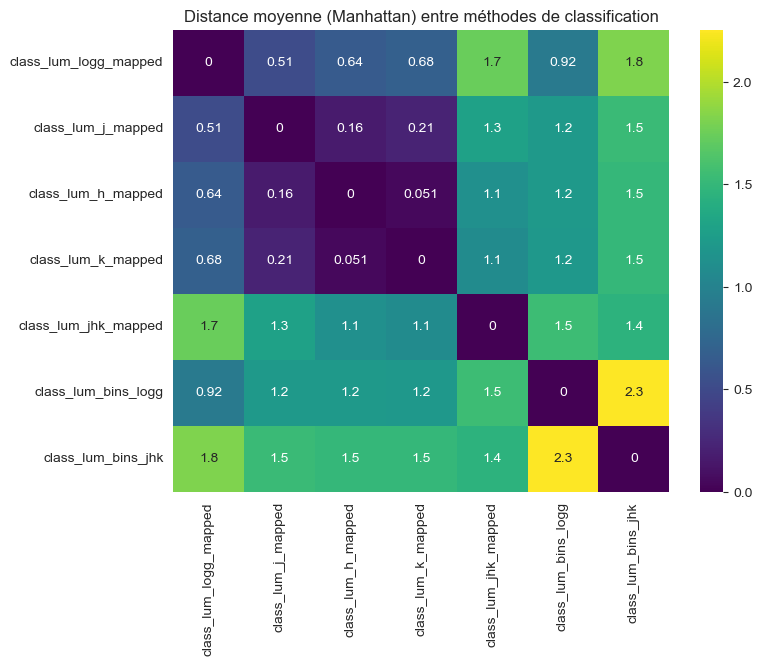

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

lum_classes = [
    'class_lum_logg_mapped',
    'class_lum_j_mapped',
    'class_lum_h_mapped',
    'class_lum_k_mapped',
    'class_lum_jhk_mapped',
    'class_lum_bins_logg',
    'class_lum_bins_jhk'
]


print(df[lum_classes].isnull().sum())

n_methods = len(lum_classes)
distance_matrix = np.zeros((n_methods, n_methods))

for i in range(n_methods):
    for j in range(n_methods):
        mean_dist = (df[lum_classes[i]] - df[lum_classes[j]]).abs().mean()
        distance_matrix[i, j] = mean_dist

dist_df = pd.DataFrame(
    distance_matrix,
    index=lum_classes,
    columns=lum_classes
)

print("Matrice des distances moyennes entre méthodes :")
print(dist_df)

# Heatmap pour visualiser
plt.figure(figsize=(8,6))
sns.heatmap(dist_df, annot=True, cmap='viridis')
plt.title("Distance moyenne (Manhattan) entre méthodes de classification")
plt.show()


In [84]:
df.describe()

df.columns

Index(['apogee_id', 'teff', 'logg', 'j', 'h', 'k', 'GAIAEDR3_PARALLAX',
       'class_spectral', 'class_lum_logg', 'class_lum_j', 'class_lum_h',
       'class_lum_k', 'class_lum_jhk', 'class_lum_logg_mapped',
       'class_lum_j_mapped', 'class_lum_h_mapped', 'class_lum_k_mapped',
       'class_lum_jhk_mapped', 'class_lum_bins', 'avg_jhk',
       'class_lum_bins_jhk', 'class_lum_bins_logg'],
      dtype='object')

In [88]:
df_classes = df[['apogee_id','class_spectral', 'class_lum_logg', 'class_lum_jhk', 'class_lum_bins_logg', 'class_lum_bins_jhk']]

df_classes.describe()

,class_lum_bins_logg,class_lum_bins_jhk
count,594011.000000,594011.000000
mean,4.524692,3.595206
std,2.148204,1.608923
min,0.000000,0.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,7.000000,5.000000
max,7.000000,7.000000


In [89]:
# save classes to csv
df_classes.to_csv('../../data/classes.csv', index=False)
